# Employee retention

### - Predict when employees are going to quit (churn rate)
- XGBoost decision tree model, 80% accuracy to predict churn

### - Understand main drivers (feature importance)
- Length of employment and salary are two main drivers: invest in loyalty rewards, hiring salary

### - model improvement: need long-term data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
home = os.getcwd()
dir = os.path.dirname(home) #"data_challenge_3" folder

In [2]:
data = pd.read_csv(os.path.join(dir,r'employee_retention.csv'), index_col = 0, header = 0)
profile = pandas_profiling.ProfileReport(data)
display(profile)

### Prediction outcome is the churn rate
- 11,192/34,702 employees are currently employed with NaN quit_date

In [332]:
#print(list(data))
#ax = data.hist()

#### Clean the format of date data and add length of employment in months.

In [129]:
from datetime import datetime

# define function to convert all formats to datetime obj
# important not to name input as datetime
def clean_format(date):
    POSSIBLE_FORMATS = ['%Y-%m-%d','%m.%d.%Y']
    if date in [np.nan]: 
        return date
    else: 
        for format in POSSIBLE_FORMATS:
            try:
                return datetime.strptime(date, format)
                pass
            except:
                pass                

# define function to calculate length of employment
# input is list [joindate,quitdate(with NaN)]
def length(input):
    current = datetime(2015, 12, 13, 0, 0)
    if input[1] in [np.nan]: 
        return (input[1] - input[0]).days/30
    else: 
        return (current - input[0]).days/30

In [130]:
# clean up format while remaining all nan
joindate = [clean_format(x) for x in data['join_date']]
quitdate = [clean_format(x) for x in data['quit_date']]
# calculate length of employment for former employee
length = pd.DataFrame({'join': joindate,
                      'quit': quitdate}).apply(length, axis = 1)

#### Define target outcome churn:

In [131]:
# 0 for current employee and 1 for former employee
churn = [0 if i in [np.nan] else 1 for i in quitdate]

In [292]:
# Make new data 
newdata = data.drop(columns = ['employee_id','join_date','quit_date'])
newdata ['length_employed'] = length
newdata ['churn'] = churn
# Change data type of company_id to categorical
newdata ['company'] = newdata['company_id'].astype('str')
newdata.drop(columns = ['company_id'], inplace = True)

In [293]:
# Double check range of dates
print("Number of employees joined before 2011-01-24:")
print(sum([i < datetime(2011, 1, 24, 0, 0) for i in joindate]))

print("Number of employees quit before 2011-01-24:")
print(sum([i < datetime(2011, 1, 24, 0, 0) if i not in [np.nan] else False for i in quitdate]))

# Remove these data since the majority falls in churn = 0
newdata = newdata[[i > datetime(2011, 1, 23, 0, 0) for i in joindate]]

Number of employees joined before 2011-01-24:
10000
Number of employees quit before 2011-01-24:
9604


In [294]:
# Remove entries with seniority >80yrs
newdata = newdata[newdata['seniority'] < 80]

# Remove entries with NA salary
newdata = newdata.dropna(axis = 'index')

/Users/jing/anaconda3/envs/insight/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/jing/anaconda3/envs/insight/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


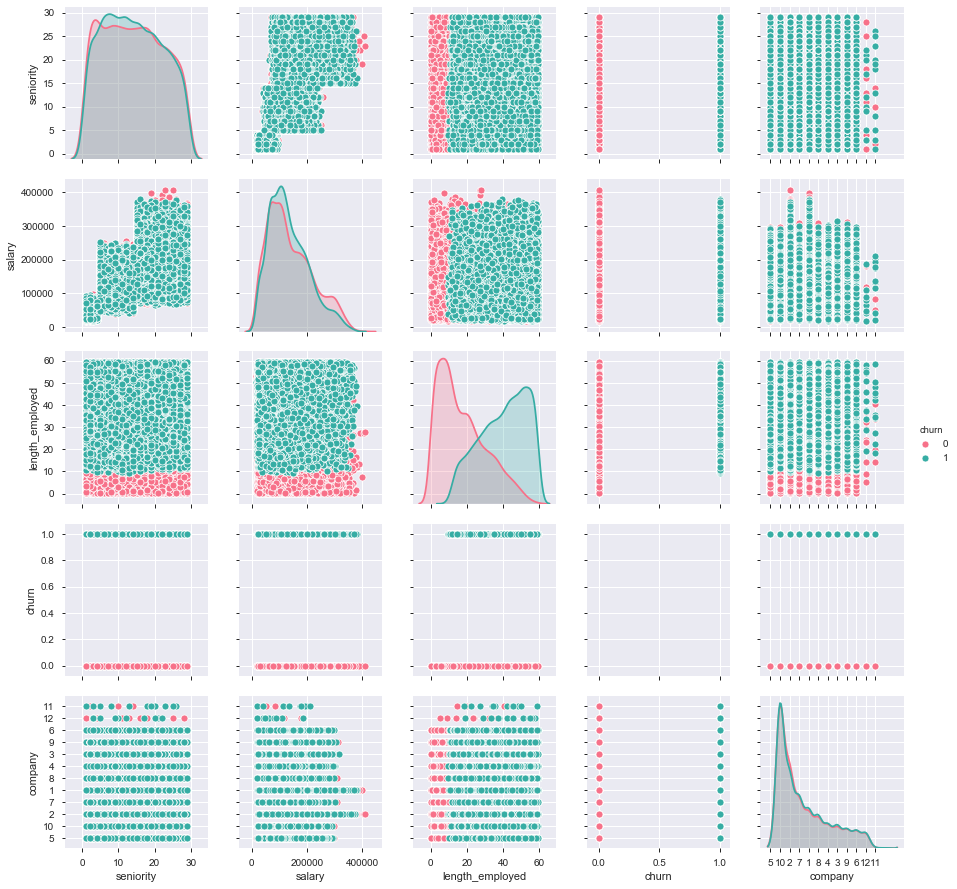

In [295]:
# Plot all features
g = sns.pairplot(newdata,hue = 'churn',palette="husl")

In [296]:
# rate of churn/former employee in new data
sum(newdata['churn'])/newdata.shape[0]

0.5468705285965414

In [297]:
newdata.dtypes

dept                object
seniority            int64
salary             float64
length_employed    float64
churn                int64
company             object
dtype: object

In [298]:
newdata['dept'].value_counts()

customer_service    9089
engineer            4568
data_science        3157
sales               3148
marketing           3132
design              1367
Name: dept, dtype: int64

## Pre-processing
- One-hot encoding for dept and company
- scale

In [299]:
# Create dummy variable
X = pd.get_dummies (newdata.drop(columns = 'churn'), drop_first = True)
print (str(X.shape))

# Save feature names
X_col = X.columns
X.head()

(24461, 19)


,seniority,salary,length_employed,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,company_10,company_11,company_12,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9
1,21,191000.0,55.700000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,9,90000.0,45.233333,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,20,298000.0,32.633333,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
5,20,180000.0,17.700000,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
6,18,119000.0,41.966667,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [300]:
# Scale to 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = X_col)
X.head()

,seniority,salary,length_employed,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,company_10,company_11,company_12,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9
0,0.714286,0.445013,0.936552,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.285714,0.186701,0.760247,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.678571,0.718670,0.548007,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.678571,0.416880,0.296463,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.607143,0.260870,0.705222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split into training and test set
- stratify by outcome (though outcome is already pretty balanced with rate = 0.55)
- credit to https://github.com/hamzaben86/Employee-Churn-Predictive-Model/blob/master/Employee%20Churn%20Model.ipynb

In [301]:
y = np.array(newdata['churn'])

In [302]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=7,
                                                    stratify=y)  
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (19568, 19)
Number transactions y_train dataset:  (19568,)
Number transactions X_test dataset:  (4893, 19)
Number transactions y_test dataset:  (4893,)


### Model
- colinearity between seniority and salary: L1 logistic regression for feature importance

In [303]:
# selection of algorithms to consider and set performance measure
# https://chrisalbon.com/machine_learning/logistic_regression/logistic_regression_with_l1_regularization/
# Libraries for data modelling:
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

models = []

# default l2 reg with c=1
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', 
                                                         random_state=7,
                                                         class_weight='balanced'))) 

# C = [10, 1, .1, .001]
# L1 regularization
models.append(('Lasso', LogisticRegression(penalty = 'l1',
                                           solver='liblinear', random_state=7,
                                           class_weight='balanced')))

models.append(('Random Forest', RandomForestClassifier(n_estimators=100, random_state=7)))
models.append(('SVM', SVC(gamma='auto', random_state=7)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree Classifier',
               DecisionTreeClassifier(random_state=7)))
models.append(('Gaussian NB', GaussianNB()))
models.append(('XGB',XGBClassifier(objective="binary:logistic", random_state=42)))

In [304]:
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
# from sklearn.datasets import make_classification

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score

acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD',
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=col)
i = 0

In [305]:
# evaluate each model using cross-validation
for name, model in models:
    # 10-fold cross-validation
    kfold = model_selection.KFold(n_splits=10, random_state=7) 

    # accuracy scoring
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train,
                                                     cv=kfold, scoring='accuracy')
    
    # roc_auc scoring
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, 
                                                     cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1

df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
7,XGB,88.48,0.61,79.55,0.51
3,SVM,88.20,0.57,79.51,0.69
1,Lasso,88.06,0.55,78.61,0.81
0,Logistic Regression,88.05,0.55,78.65,0.85
6,Gaussian NB,87.56,0.75,77.07,0.94
2,Random Forest,86.33,0.68,77.35,0.76
4,KNN,83.90,0.63,76.95,0.68
5,Decision Tree Classifier,72.37,0.88,72.50,0.91


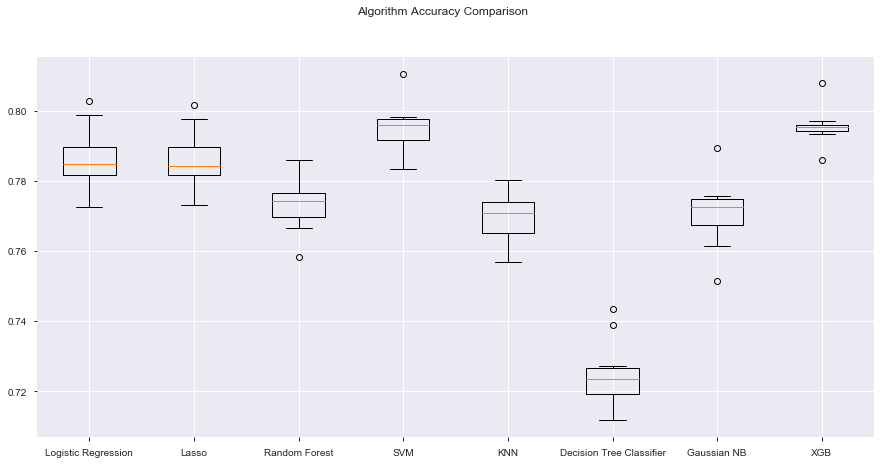

In [307]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()

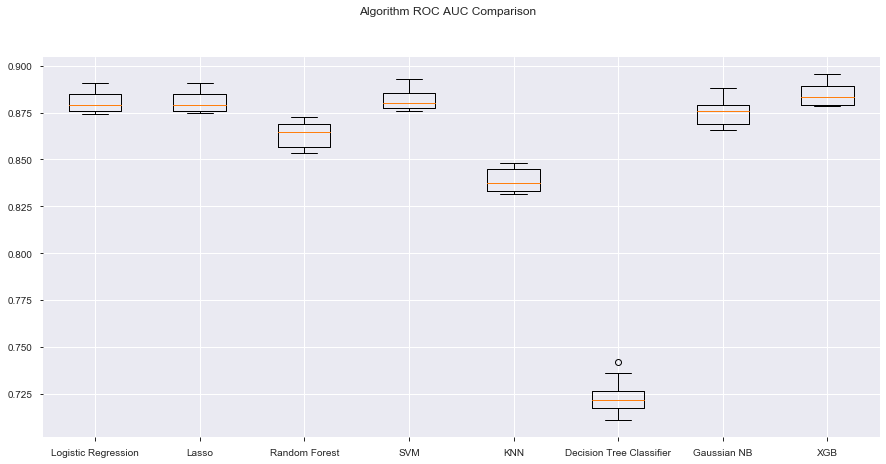

In [308]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm ROC AUC Comparison')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      2217
           1       0.79      0.85      0.82      2676

    accuracy                           0.80      4893
   macro avg       0.80      0.79      0.80      4893
weighted avg       0.80      0.80      0.80      4893



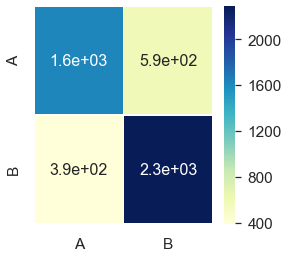

In [316]:
# XGBoost decision tree model performs best based on 10-fold CV AUC-ROC and accuracy
model = XGBClassifier(objective="binary:logistic", random_state=42)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
report = classification_report(y_test, predicted)

# Feed the Confusion matrix into the formatting dataframe
df_cm = pd.DataFrame(matrix, index = [i for i in "AB"],
                     columns = [i for i in "AB"])
#df_cm = pd.DataFrame(array, range(6),range(6)) # use numerical col/row names.
sns.set(font_scale=1.4)#for label size
plt.figure(figsize = (4,4))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap="YlGnBu",linewidths=.5)# font size
print(report)

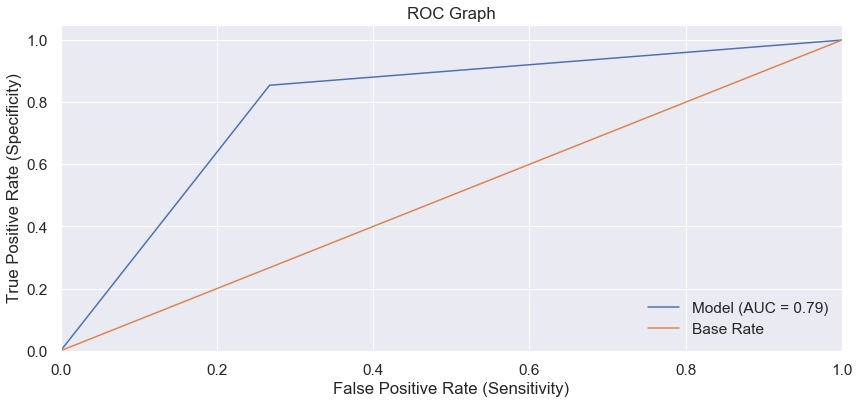

In [331]:
roc_auc = roc_auc_score(y_test, predicted)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, predicted)
# rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_opt.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))

# Plot XGBoost ROC
plt.plot(fpr, tpr, label='Model (AUC = %0.2f)' % roc_auc)
# Plot Random Forest ROC
# plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % rf_opt_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Sensitivity)')
plt.ylabel('True Positive Rate (Specificity)')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

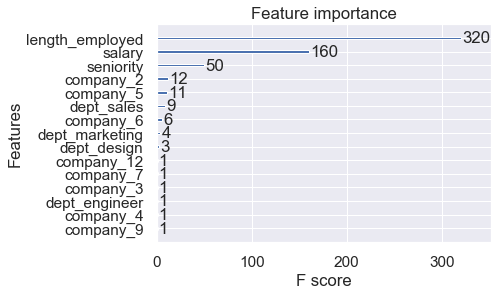

In [321]:
# Feature importance
# credit: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
from xgboost import plot_importance

plot_importance(model)
plt.show()

## Length of employment, salary and seniority are top determinants of churn.

In [325]:
importances = model.feature_importances_
df_param_coeff = pd.DataFrame(columns=['Feature', 'Coefficient'])
for i in range(19):
    feat = X_train.columns[i]
    coeff = importances[i]
    df_param_coeff.loc[i] = (feat, coeff)
df_param_coeff.sort_values(by='Coefficient', ascending=False, inplace=True)
df_param_coeff = df_param_coeff.reset_index(drop=True)
df_param_coeff.head(10)

,Feature,Coefficient
0,length_employed,0.782126
1,salary,0.057331
2,company_3,0.024329
3,seniority,0.018473
4,company_4,0.017225
5,company_6,0.015207
6,company_2,0.012119
7,company_9,0.012046
8,dept_marketing,0.011892
9,dept_sales,0.010983
